In [4]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
DATASET_DIR = 'dataset/news_dataset.csv'
SAVE_MODEL_DIR = 'models/svm'


In [2]:
# ================== EMBEDDING DATA INPUT  ==================
from phobert_svm_pipeline import prepare_and_save_embeddings

prepare_and_save_embeddings(
    DATASET_DIR,    
    save_dir=SAVE_MODEL_DIR
)

>> Embedding train set...
>> Embedding test set...
>> Saved embeddings and texts to models/phobert_svm_model


In [1]:
from phobert_svm_pipeline import train_svm_base, device

print(f"Using device: {device}")
print("********LINEAR KERNEL********")
clf, le, X_test_txt, y_test = train_svm_base(kernel='linear', model_file_name='svm_linear_model')


d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>> Loading PhoBERT from local: models/phobert-base
Using device: cpu
********LINEAR KERNEL********
>> Evaluation:
                   precision    recall  f1-score   support

        chính trị       0.81      0.86      0.83       757
        công nghệ       0.83      0.83      0.83       757
         giáo dục       0.80      0.83      0.81       757
          kinh tế       0.79      0.79      0.79       758
        pháp luật       0.92      0.90      0.91       757
sức khỏe đời sống       0.77      0.71      0.74       757
         thế giới       0.83      0.87      0.85       758
         thể thao       0.97      0.96      0.97       757
 văn hóa giải trí       0.81      0.77      0.79       757
               xe       0.91      0.93      0.92       757

         accuracy                           0.84      7572
        macro avg       0.84      0.84      0.84      7572
     weighted avg       0.84      0.84      0.84      7572

>> Saved SVM model to models/svm/svm_linear_model.joblib


In [2]:
from phobert_svm_pipeline import train_svm_base, device

print(f"Using device: {device}")
print("********RBF KERNEL********")
clf_rbf, le_rbf, X_test_txt_rbf, y_test_rbf = train_svm_base(kernel='rbf', model_file_name='svm_rbf_model')

Using device: cpu
********RBF KERNEL********
>> Evaluation:
                   precision    recall  f1-score   support

        chính trị       0.82      0.87      0.85       757
        công nghệ       0.84      0.84      0.84       757
         giáo dục       0.81      0.84      0.83       757
          kinh tế       0.80      0.80      0.80       758
        pháp luật       0.92      0.90      0.91       757
sức khỏe đời sống       0.78      0.73      0.75       757
         thế giới       0.84      0.87      0.86       758
         thể thao       0.98      0.97      0.97       757
 văn hóa giải trí       0.83      0.78      0.80       757
               xe       0.91      0.94      0.93       757

         accuracy                           0.85      7572
        macro avg       0.85      0.85      0.85      7572
     weighted avg       0.85      0.85      0.85      7572

>> Saved SVM model to models/svm/svm_rbf_model.joblib


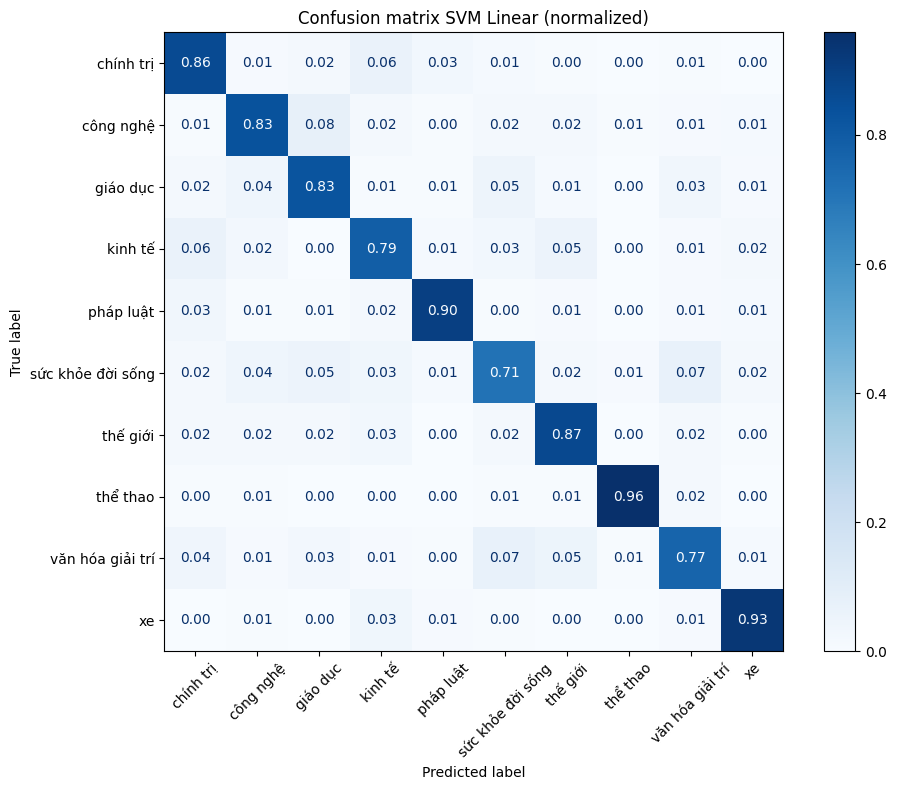

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


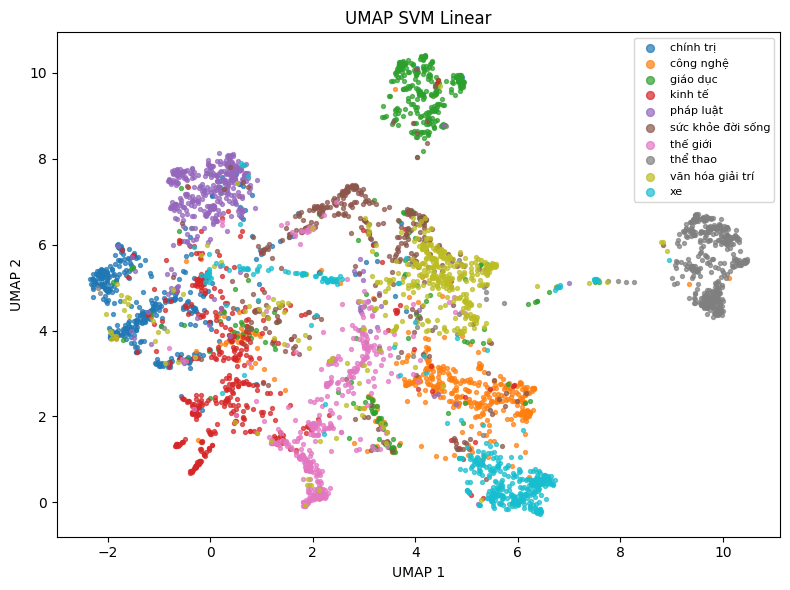

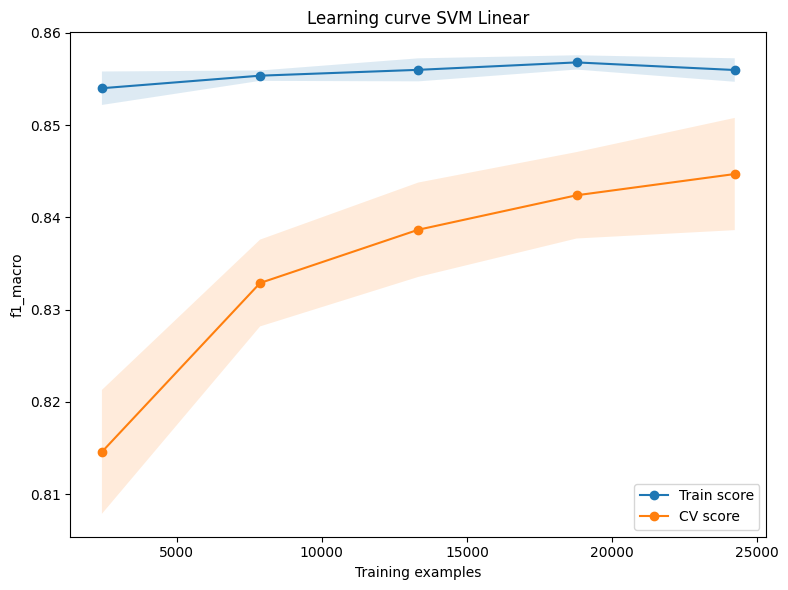

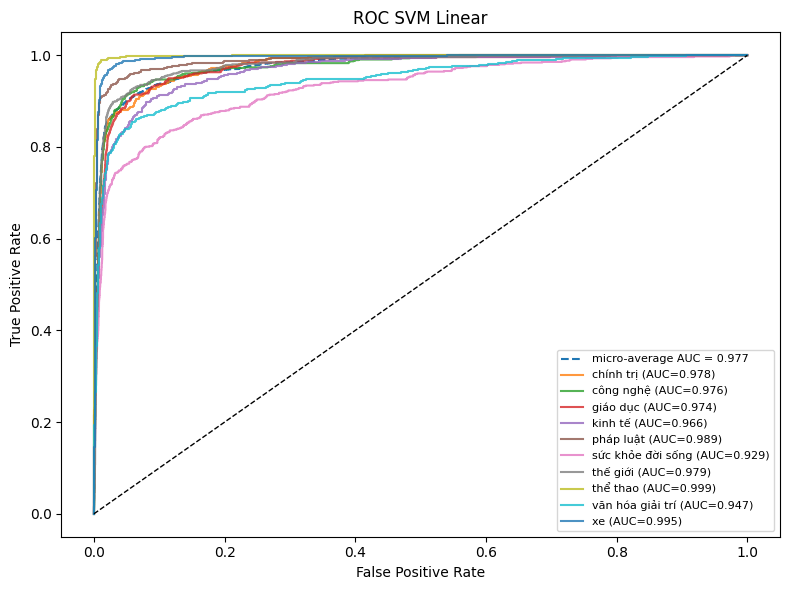

In [8]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL LINEAR ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm, plot_roc_multiclass
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/svm_linear_model.joblib")
le = joblib.load(f"{SAVE_MODEL_DIR}/label_encoder.joblib")

X_train = np.load(f"{SAVE_MODEL_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_MODEL_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_MODEL_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_MODEL_DIR}/y_test.npy")

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf, le,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix SVM Linear"
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    le=le,
    title="UMAP SVM Linear"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve SVM Linear"
)

# 4) ROC (dùng EMBEDDING sẵn)
plot_roc_multiclass(clf, le, X_emb=X_test, y_true_labels=y_test_num, title="ROC SVM Linear")

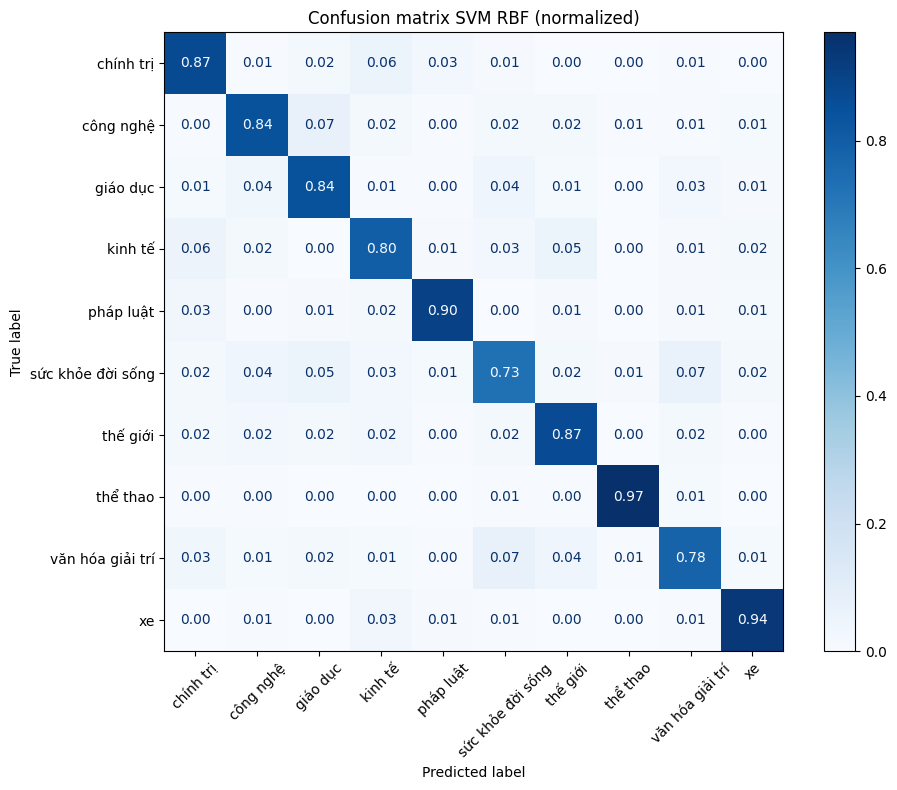

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


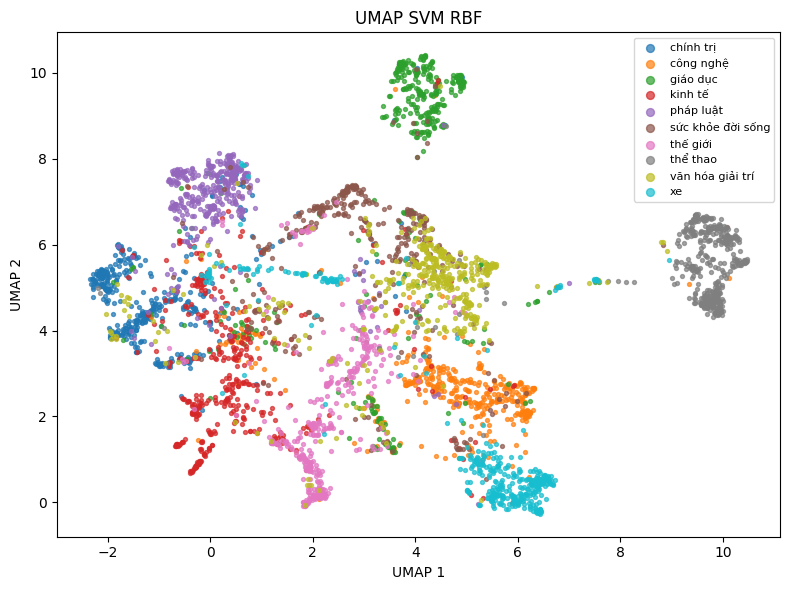

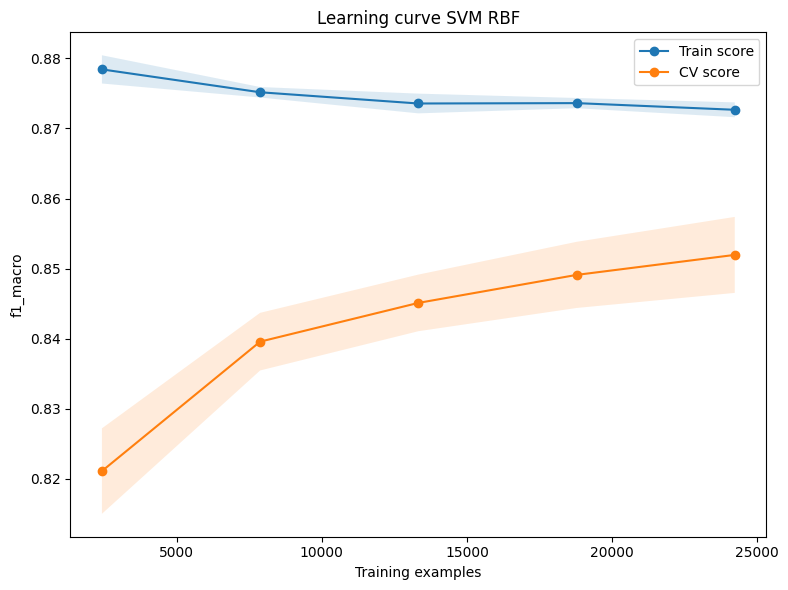

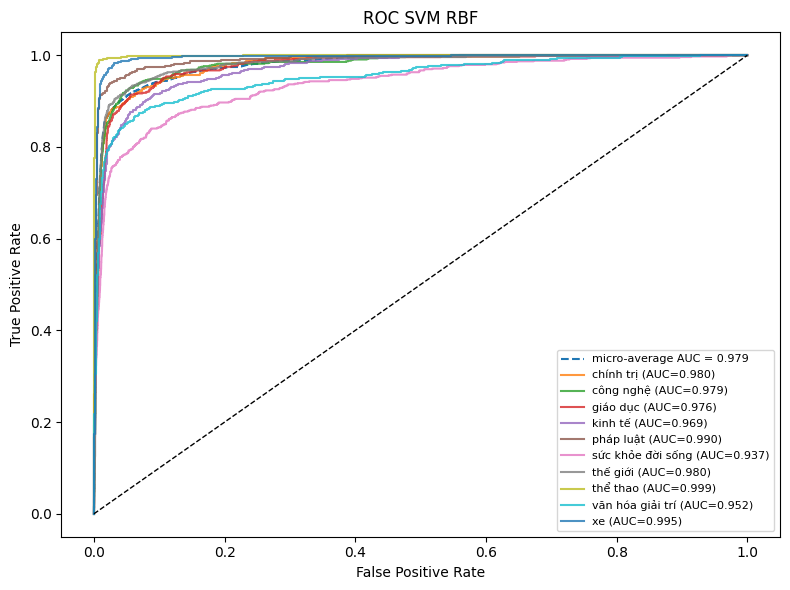

In [9]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL RBF ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm, plot_roc_multiclass
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/svm_rbf_model.joblib")
le = joblib.load(f"{SAVE_MODEL_DIR}/label_encoder.joblib")

X_train = np.load(f"{SAVE_MODEL_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_MODEL_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_MODEL_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_MODEL_DIR}/y_test.npy")

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf, le,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix SVM RBF"
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    le=le,
    title="UMAP SVM RBF"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve SVM RBF"
)

# 4) ROC (dùng EMBEDDING sẵn)
plot_roc_multiclass(clf, le, X_emb=X_test, y_true_labels=y_test_num, title="ROC SVM RBF")